<a href="https://colab.research.google.com/github/ArifAygun/CustomerEye/blob/main/Company_Reviews(14).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### IMPORT LIBRARIES AND DATASET

In [12]:
!pip install pycountry

In [13]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import pycountry

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

# Change directory to the analysis folder
%cd /content/drive/My Drive/Analysis_1/

# Read CSV files into DataFrames
df1 = pd.read_csv('Freedom_Debt_Relief.csv')
df2 = pd.read_csv('Millennium_Trust.csv')
df3 = pd.read_csv('Advance_America.csv')

print(df1.info(), df1.head())
print(df2.info(), df2.head())
print(df3.info(), df3.head())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Analysis_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39078 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    39068 non-null  object
 1   Reviews Count    39078 non-null  object
 2   Country Code     39078 non-null  object
 3   Experience Date  39078 non-null  object
 4   Rating           39078 non-null  int64 
 5   Review Date      39078 non-null  object
 6   Review Title     39074 non-null  object
 7   Review Text      34241 non-null  object
 8   Reply Date       37731 non-null  object
 9   Reply Text       37731 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB
None     Reviewer Name Reviews Count Country Code    Experience Date  Rating  \
0  Andrea Sciotti      2reviews           US  December 

### DATA PREPROCESSING

In [15]:
import pandas as pd
import pycountry

# Function for preprocessing
def preprocessing(df, reply_text):
    # Convert 'Reviews Count' to integers
    df['Reviews Count'] = df['Reviews Count'].str.extract('(\d+)').astype(int)

    # Replace the specified text in 'Reply Date' column
    df['Reply Date'] = df['Reply Date'].str.replace(reply_text, '').str.strip()

    # Convert 'Experience Date', 'Review Date', and 'Reply Date' to datetime
    date_columns = ['Experience Date', 'Review Date', 'Reply Date']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Extract 'Year' from 'Review Date' and create a new column
    df['Year'] = df['Review Date'].dt.year

    # Drop rows with NaN values in 'Experience Date', 'Review Date', or 'Reply Date'
    df = df.dropna(subset=date_columns)

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Concatenate 'Review Title' and 'Review Text' into a new 'Reviews' column
    df.loc[:, 'Reviews'] = df['Review Title'].astype(str) + ' ' + df['Review Text'].astype(str)

    # Rename 'Reply Text' column to 'Replies'
    df = df.rename(columns={'Reply Text': 'Replies', 'Country Code': 'Country'})

    # Add a new column with country names
    df['Countries'] = df['Country'].apply(lambda code: pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else None)

    # Calculate response time between 'Experience Date' and 'Review Date' in days
    df['Exp to Review'] = (df['Review Date'] - df['Experience Date']).dt.total_seconds() / 86400

    # Calculate response time between 'Review Date' and 'Reply Date' in days
    df['Review to Reply'] = (df['Reply Date'] - df['Review Date']).dt.total_seconds() / 86400

    # Round the values to the nearest integer and convert to int
    df[['Exp to Review', 'Review to Reply']] = df[['Exp to Review', 'Review to Reply']].round(0).astype(int)

    # Drop the original 'Review Title' and 'Review Text' columns
    df = df.drop(['Reviewer Name', 'Reviews Count', 'Review Title', 'Review Text','Country'], axis=1)

    # Rearrange the columns
    df = df[['Year', 'Experience Date', 'Review Date', 'Reply Date','Exp to Review',
             'Review to Reply','Rating', 'Countries', 'Reviews', 'Replies']]

    return df

# Calculate response time for each DataFrame
df1 = preprocessing(df1, 'Reply from Freedom Debt Relief')
df2 = preprocessing(df2, 'Reply from Millennium Trust')
df3 = preprocessing(df3, 'Reply from Advance America')

# Print the updated DataFrame information
pd.set_option('display.max_columns', None)

print(df1.info())
print(df2.info())
print(df3.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36713 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             36713 non-null  float64       
 1   Experience Date  36713 non-null  datetime64[ns]
 2   Review Date      36713 non-null  datetime64[ns]
 3   Reply Date       36713 non-null  datetime64[ns]
 4   Exp to Review    36713 non-null  int64         
 5   Review to Reply  36713 non-null  int64         
 6   Rating           36713 non-null  int64         
 7   Countries        36713 non-null  object        
 8   Reviews          36713 non-null  object        
 9   Replies          36713 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 3.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29374 entries, 235 to 39327
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  

### DATA SAMPLING

In [16]:
# Function for random sampling
def perform_sampling(df):
    years_to_keep = [2021, 2022, 2023]

    # Filter data for the specified years
    filtered_df = df[df['Review Date'].dt.year.isin(years_to_keep)]

    # Count the occurrences of each rating for each year
    yearly_rating_counts = filtered_df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Perform random sampling to get 2000 datapoints
    sampled_df = pd.DataFrame()
    for year in years_to_keep:
        year_data = filtered_df[filtered_df['Review Date'].dt.year == year]
        sampled_data = year_data.sample(n=2000, replace=True)  # Adjust the sampling size as needed
        sampled_df = pd.concat([sampled_df, sampled_data])

    return sampled_df

# Apply sampling for each dataset
sampled_df1 = perform_sampling(df1)
sampled_df2 = perform_sampling(df2)
sampled_df3 = perform_sampling(df3)

# Ensure all sampled dataframes have the same number of datapoints (2000)
sampled_df1 = sampled_df1.sample(n=2000, replace=True)
sampled_df2 = sampled_df2.sample(n=2000, replace=True)
sampled_df3 = sampled_df3.sample(n=2000, replace=True)

print(sampled_df1.info())
print(sampled_df2.info())
print(sampled_df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 5826 to 5143
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             2000 non-null   float64       
 1   Experience Date  2000 non-null   datetime64[ns]
 2   Review Date      2000 non-null   datetime64[ns]
 3   Reply Date       2000 non-null   datetime64[ns]
 4   Exp to Review    2000 non-null   int64         
 5   Review to Reply  2000 non-null   int64         
 6   Rating           2000 non-null   int64         
 7   Countries        2000 non-null   object        
 8   Reviews          2000 non-null   object        
 9   Replies          2000 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 171.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 13472 to 6945
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
--

## RATINGS OVER YEARS

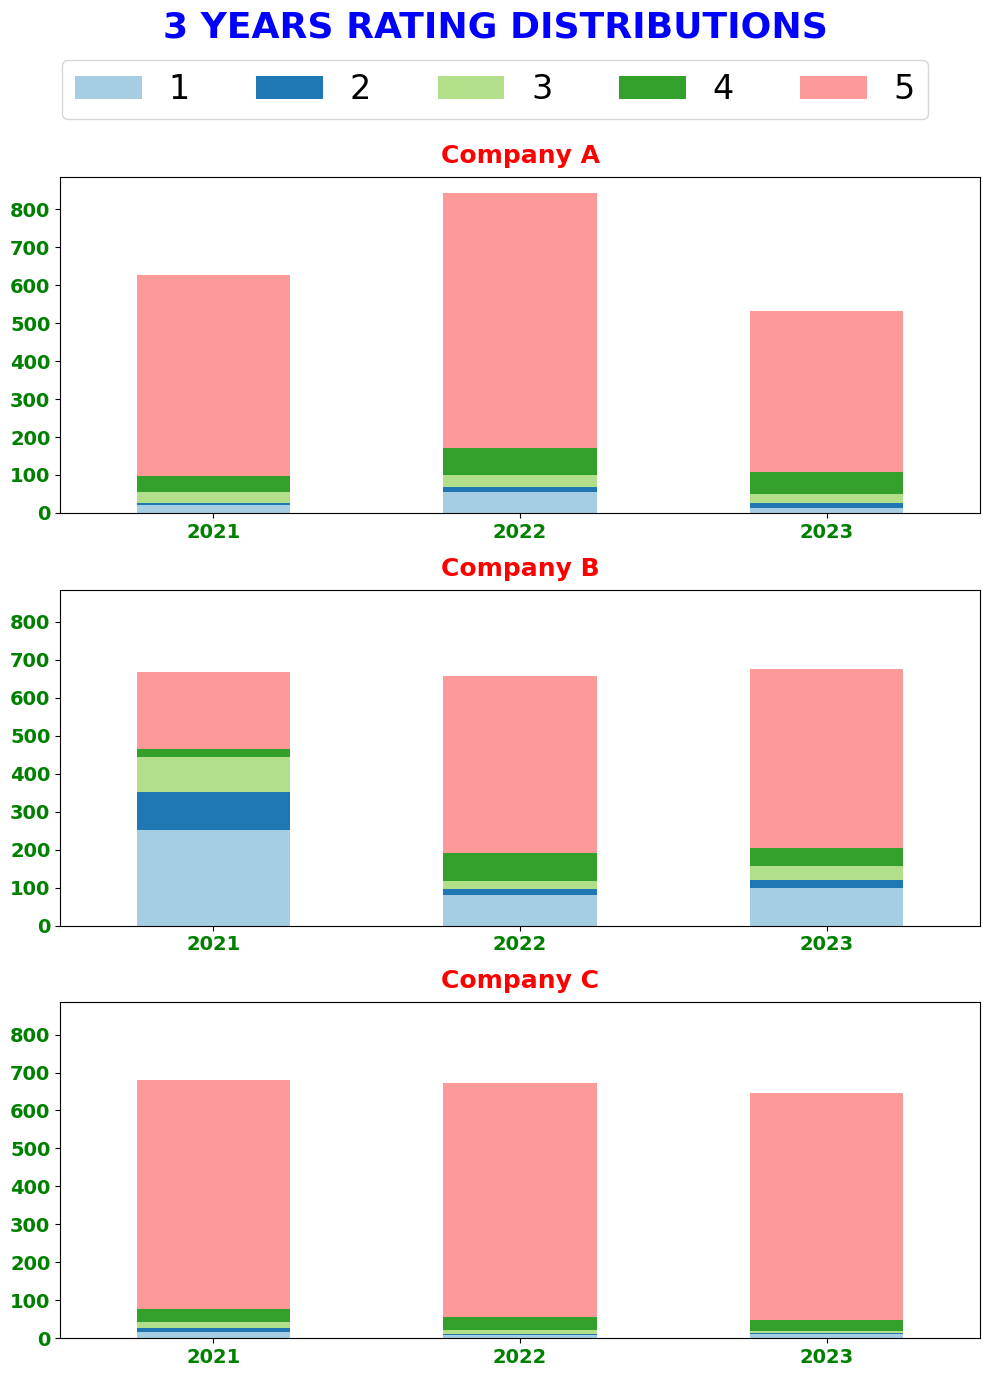

In [139]:
from matplotlib.ticker import FixedLocator

# Create a figure with three subplots for vertical stacked bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

# Set Seaborn color palette to "Paired"
sns.set_palette("Paired")

# Lists to collect handles and labels for the legend
handles = []
labels = set()  # Using a set to avoid duplicates in labels

# Plot vertical stacked bars for each rating for each DataFrame
for i, df in enumerate([sampled_df1, sampled_df2, sampled_df3]):
    yearly_rating_counts = df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Cast the years to integers
    yearly_rating_counts.index = yearly_rating_counts.index.astype(int)

    plot = yearly_rating_counts.plot(kind='bar', stacked=True, ax=axes[i], legend=False)

    # Collect handles and labels for the legend
    plot_handles, plot_labels = axes[i].get_legend_handles_labels()
    handles.extend(plot_handles)

    # Use set union to add unique labels to the set
    labels |= set(plot_labels)

    # Set labels and title for each subplot
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Company {chr(ord("A") + i)}', fontsize=18, color='red', fontweight='bold', pad=10)  # Adjust the 'pad' value as needed

    # Remove decimals in the x-axis labels
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Rotate x-axis labels to be horizontal
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=14, fontweight='bold', color='green')

    # Make y-axis labels bold and set font size using FixedLocator and FixedFormatter
    yticks = [int(ytick) for ytick in axes[i].get_yticks()]
    axes[i].yaxis.set_major_locator(FixedLocator(yticks))
    axes[i].set_yticklabels(yticks, fontsize=14, fontweight='bold', color='green')

# Sort labels in ascending order
sorted_labels = sorted(labels, key=lambda x: int(x))

# Create a combined legend for all plots horizontally with adjusted parameters
legend = fig.legend(handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, 0.91), ncol=5, borderaxespad=0.5, prop={'size': 24})

# Set legend title font size
legend.get_title().set_fontsize(14)

# Set a general title for the entire subplot
fig.suptitle('3 YEARS RATING DISTRIBUTIONS', fontsize=26, color='blue', fontweight='bold', y=1)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

# Show the vertical stacked bar charts with a single legend at the bottom
plt.show()


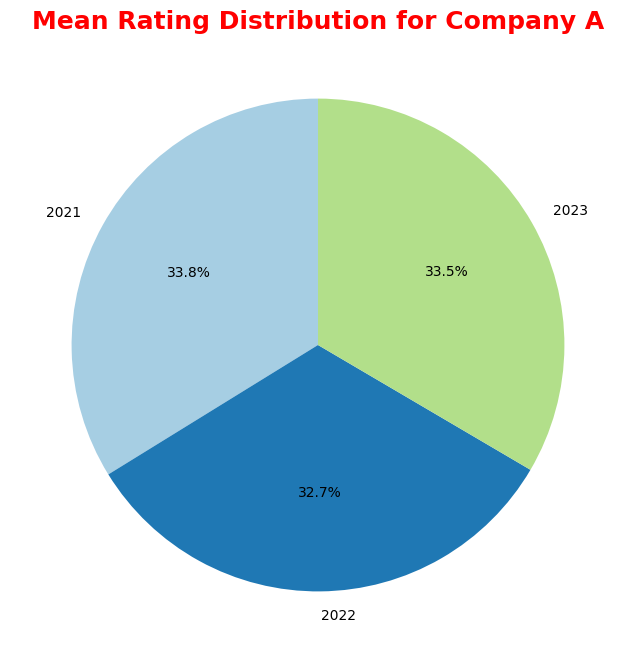

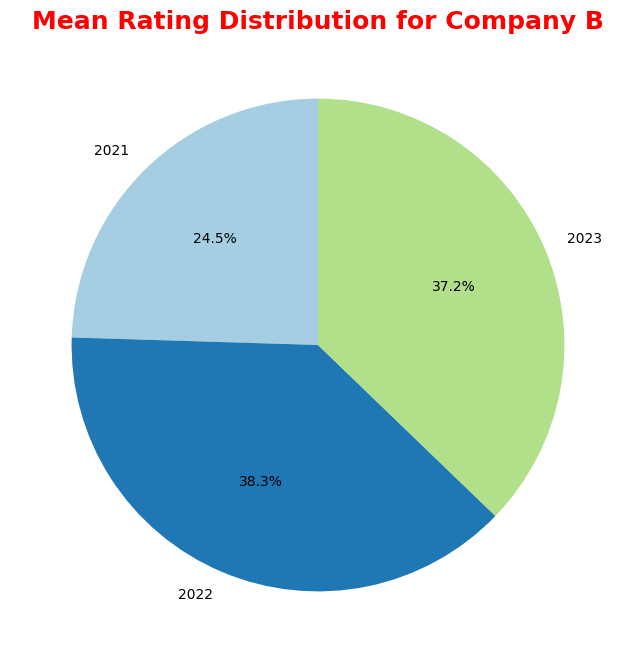

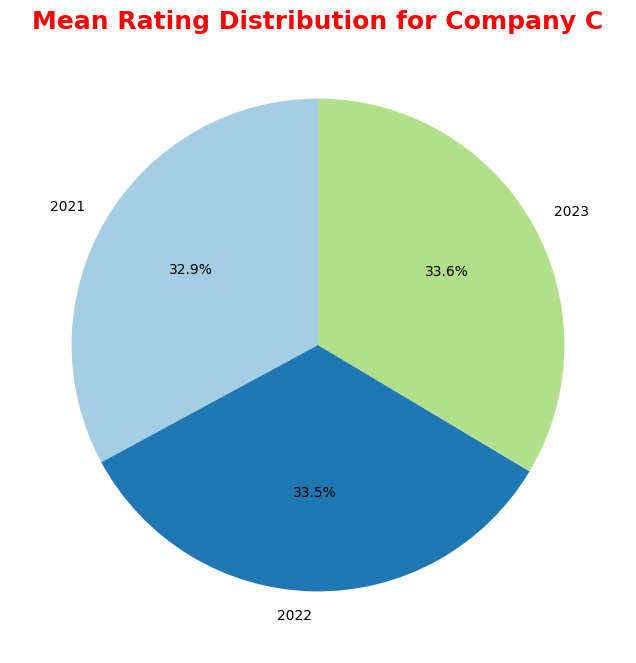

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your three DataFrames

# Create a function to plot pie charts for mean ratings by year
def plot_pie_ratings(df, company_name, color_palette):
    yearly_mean_ratings = df.groupby('Year')['Rating'].mean()

    # Create a pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(yearly_mean_ratings, labels=yearly_mean_ratings.index.astype(int), autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette(color_palette))

    # Set title for the pie chart
    ax.set_title(f'Mean Rating Distribution for {company_name}', fontsize=18, color='red', fontweight='bold')

    # Show the pie chart
    plt.show()

# Plot pie charts for mean ratings for each company
plot_pie_ratings(sampled_df1, 'Company A', 'Paired')
plot_pie_ratings(sampled_df2, 'Company B', 'Paired')
plot_pie_ratings(sampled_df3, 'Company C', 'Paired')


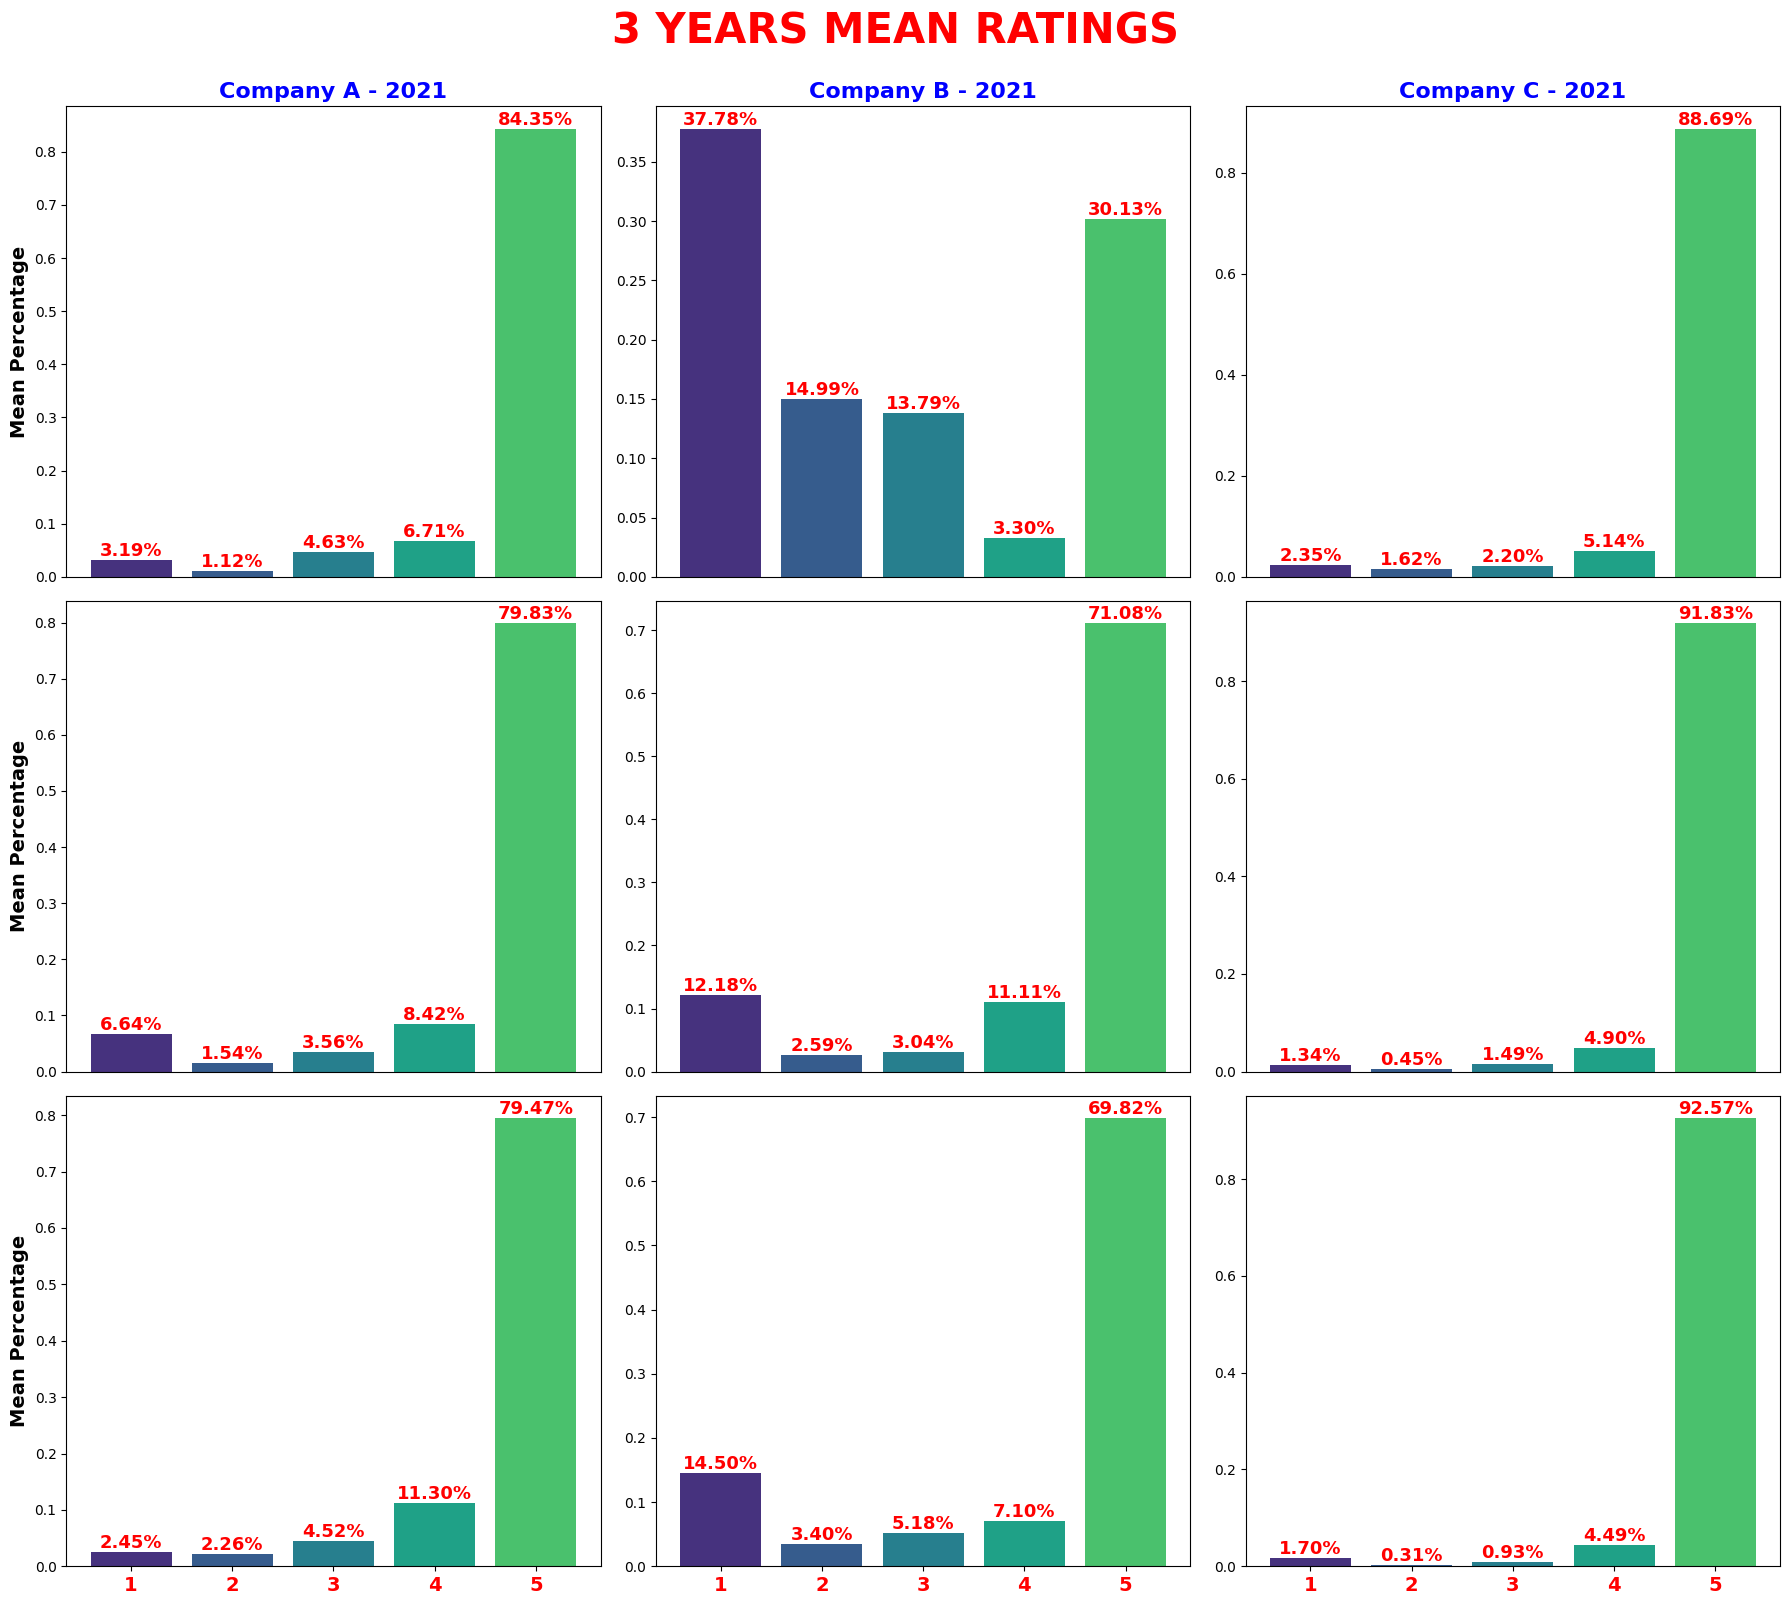

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
companies = [sampled_df1, sampled_df2, sampled_df3]
company_names = ['Company A', 'Company B', 'Company C']

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = '3 YEARS MEAN RATINGS'

# Plot bar charts for mean ratings for each company and year
plt.figure(figsize=(18, 16))

for i, company_df in enumerate(companies):
    for j, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = j * len(companies) + i + 1
        ax = plt.subplot(len(years), len(companies), subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        if j == len(years) - 1:
            plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='red')
        else:
            plt.xticks([])

        # Add labels and title
        if j == 0:
            plt.title(f'{company_names[i]} - {year}', fontsize=16, fontweight='bold', color='blue')

        if i == 0:
            plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# Set x-axis labels for the last row
plt.xticks(range(1, 6), labels=[str(i) for i in range(1, 6)], fontsize=14, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


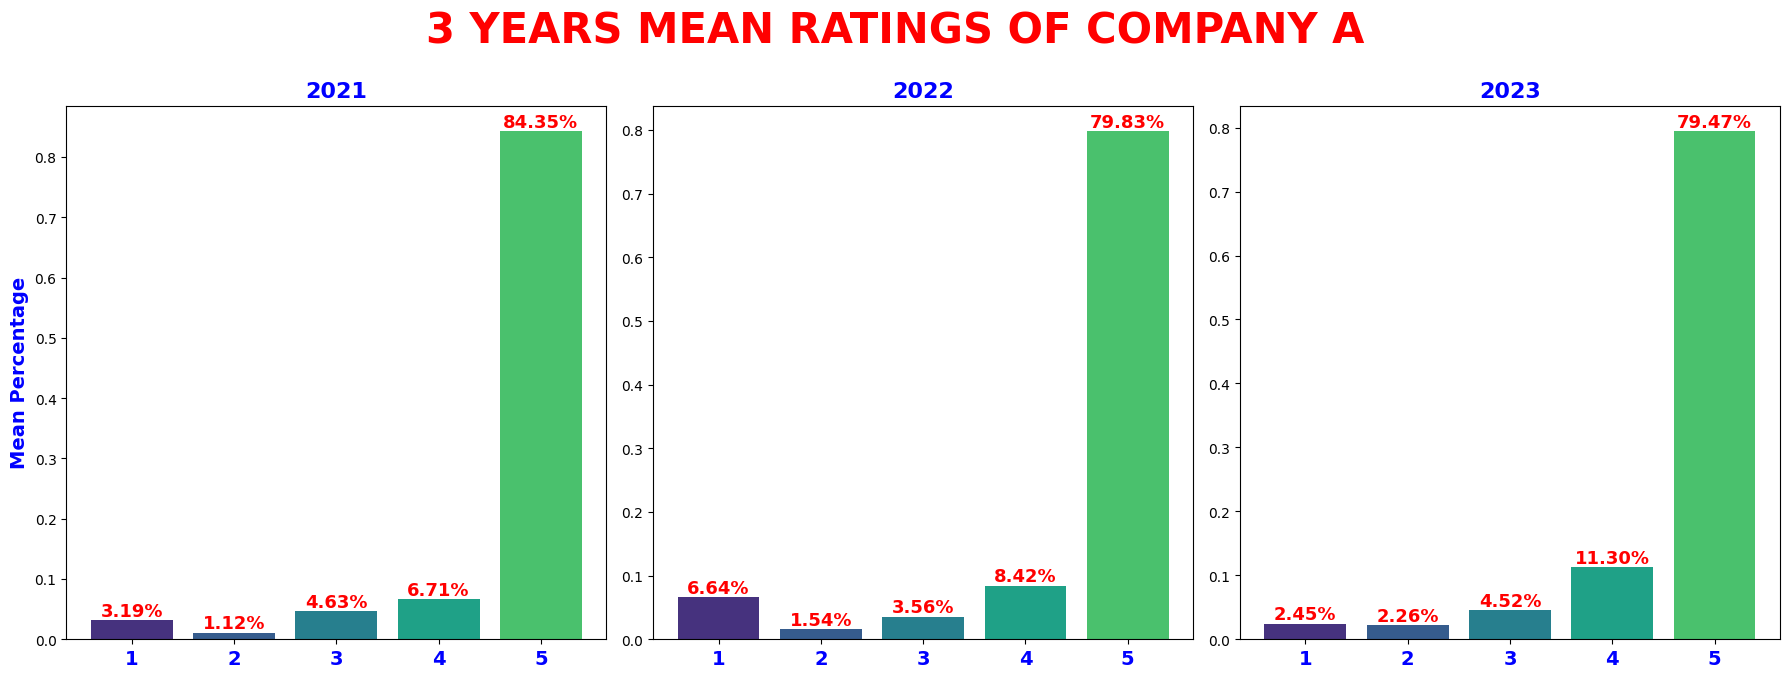

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df1 is your DataFrame for Company A
company_df = sampled_df1

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = '3 YEARS MEAN RATINGS OF COMPANY A'

# Plot bar charts for mean ratings for Company A for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


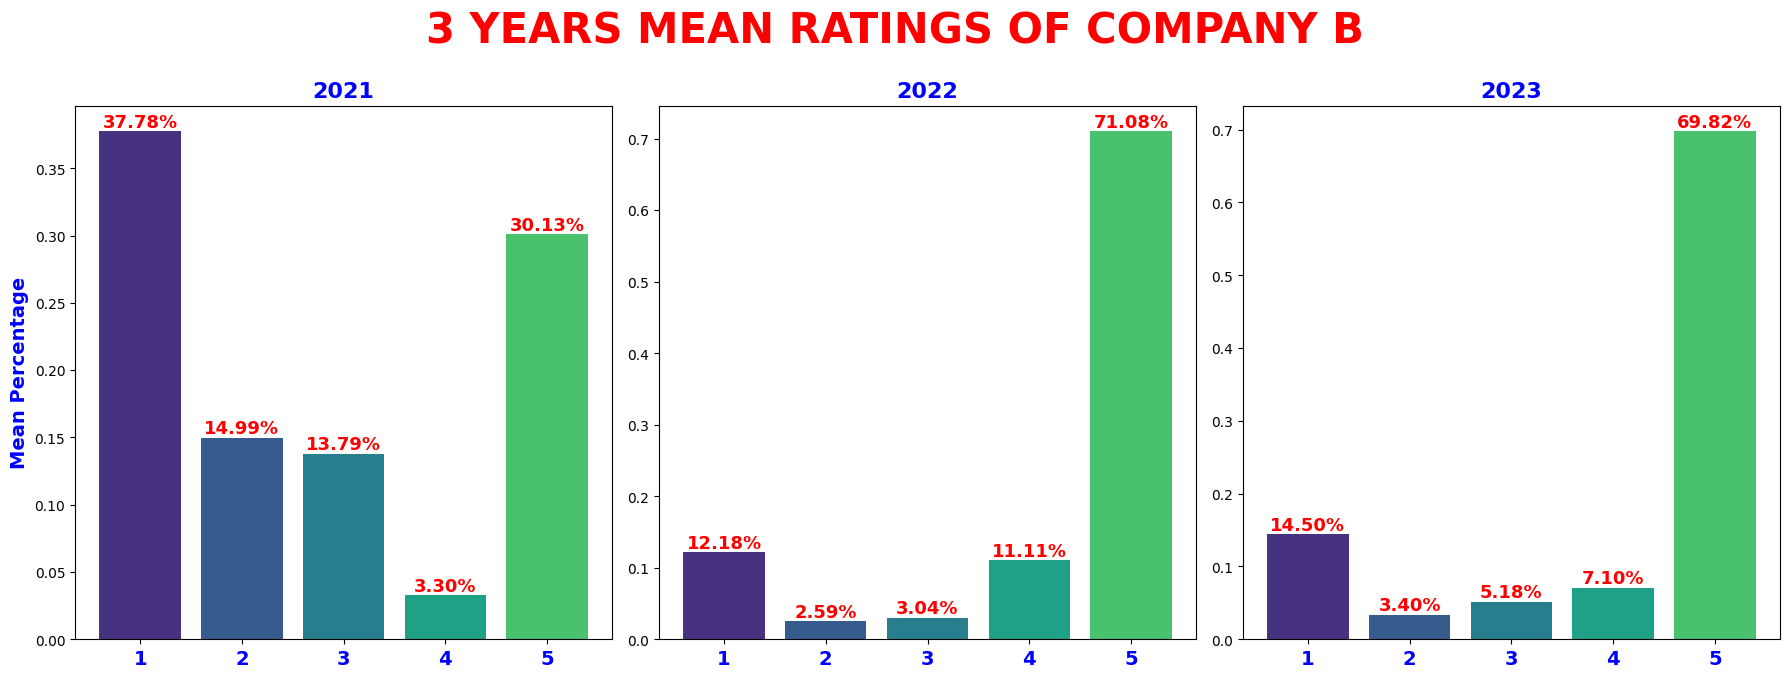

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df2 is your DataFrame for Company B
company_df = sampled_df2

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = '3 YEARS MEAN RATINGS OF COMPANY B'

# Plot bar charts for mean ratings for Company B for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


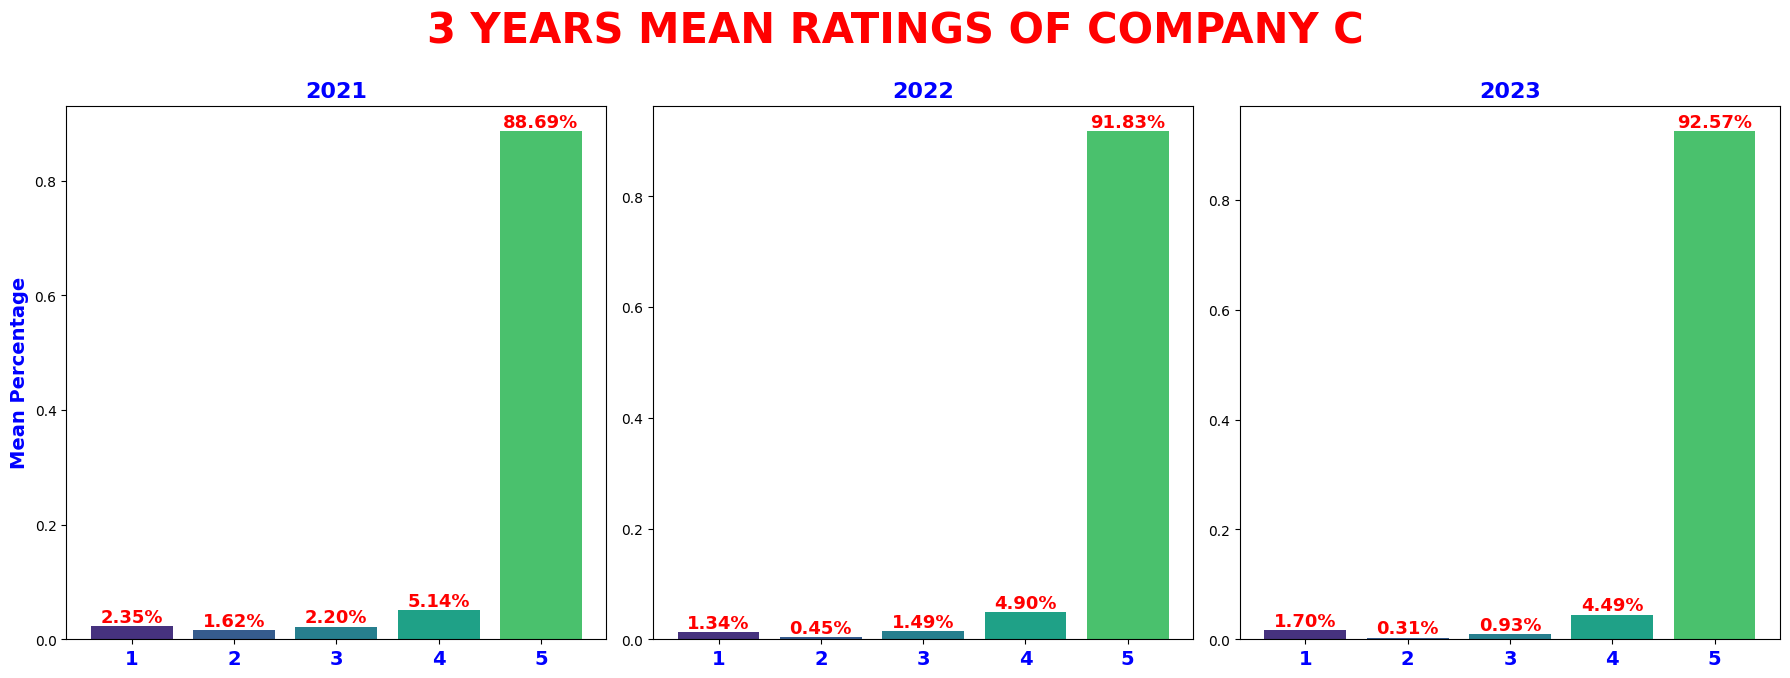

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df3 is your DataFrame for Company C
company_df = sampled_df3

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = '3 YEARS MEAN RATINGS OF COMPANY C'

# Plot bar charts for mean ratings for Company C for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


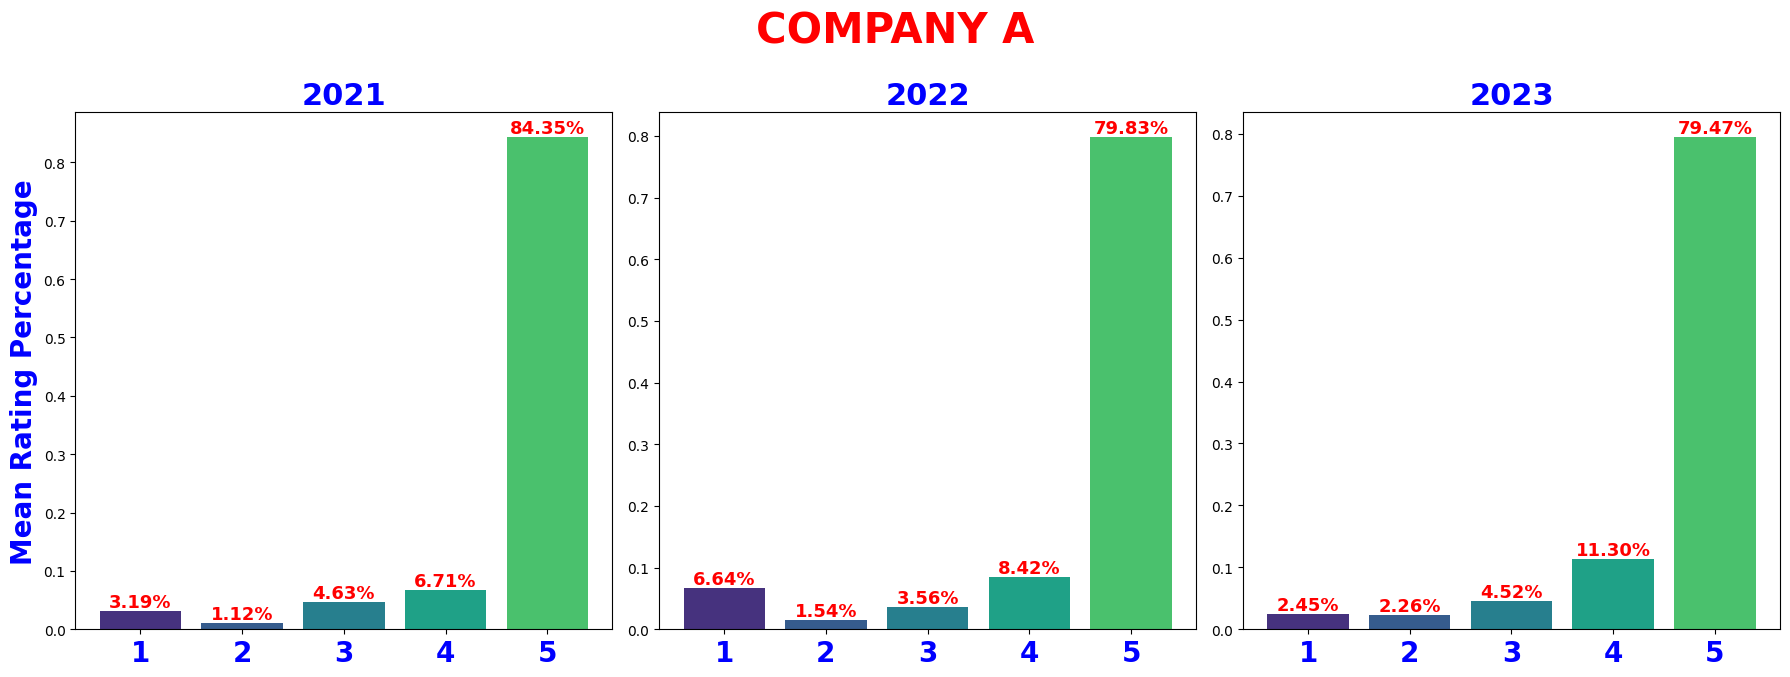

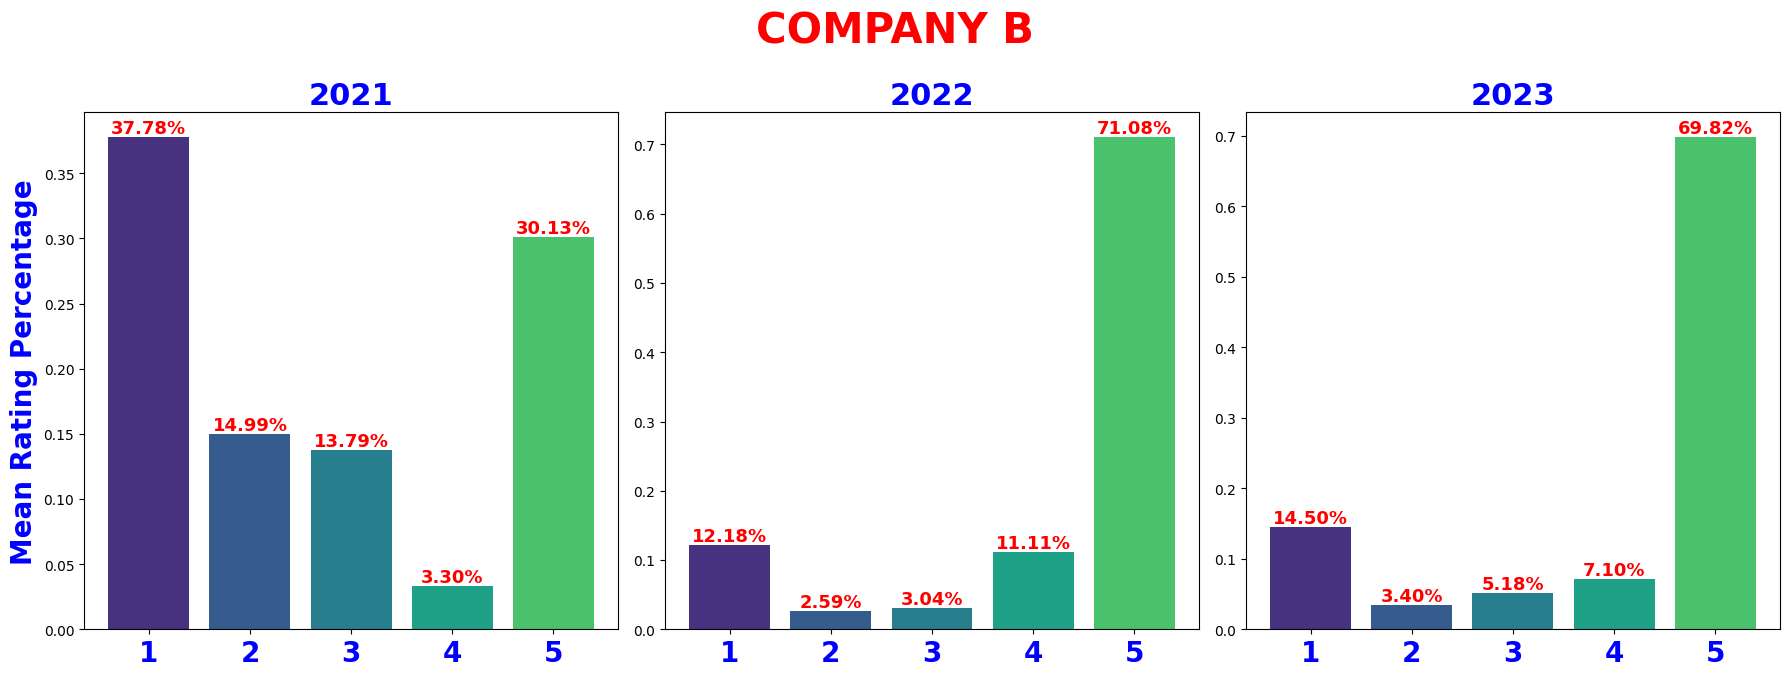

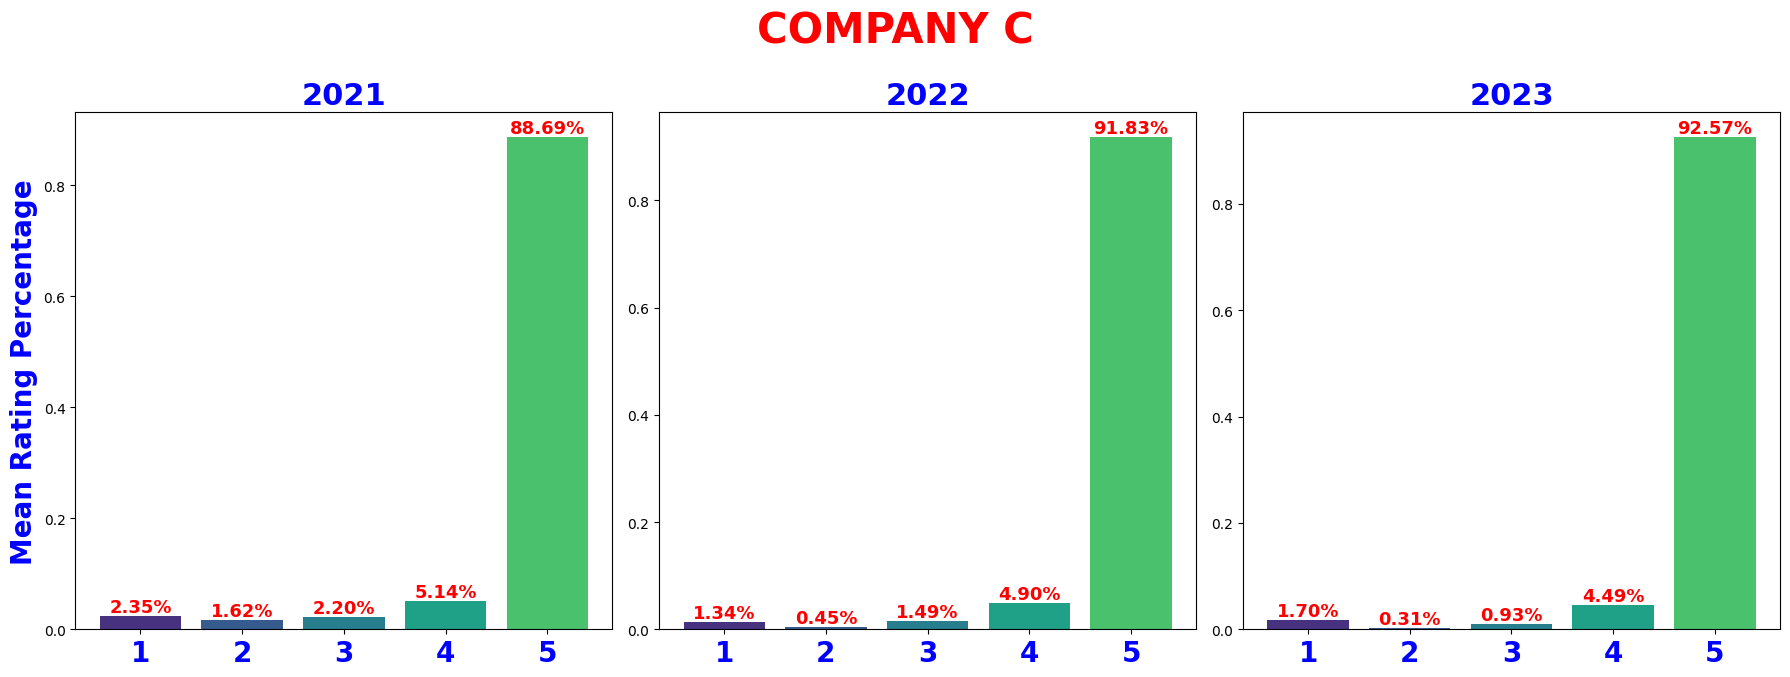

In [215]:
def plot_company_mean_ratings(company_df, company_name):
    # Define years to plot
    years = [2021, 2022, 2023]

    # General title for the entire subplot
    general_title = f'{company_name}'

    # Plot bar charts for mean ratings for the company for each year
    plt.figure(figsize=(18, 18))

    for i, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = i + 1
        ax = plt.subplot(3, 3, subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=20, fontweight='bold', color='blue')

        # Add labels and title
        plt.title(f'{year}', fontsize=22, fontweight='bold', color='blue')

        # Add y-labels for the first column
        if subplot_index % 3 == 1:
            plt.ylabel('Mean Rating Percentage', fontsize=20, fontweight='bold', color='blue')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

    # General title for the entire subplot
    plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

    # Adjust layout with a gap between subplots
    plt.tight_layout(h_pad=2)

    # Show the plot
    plt.show()

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
plot_company_mean_ratings(sampled_df1, 'COMPANY A')
plot_company_mean_ratings(sampled_df2, 'COMPANY B')
plot_company_mean_ratings(sampled_df3, 'COMPANY C')

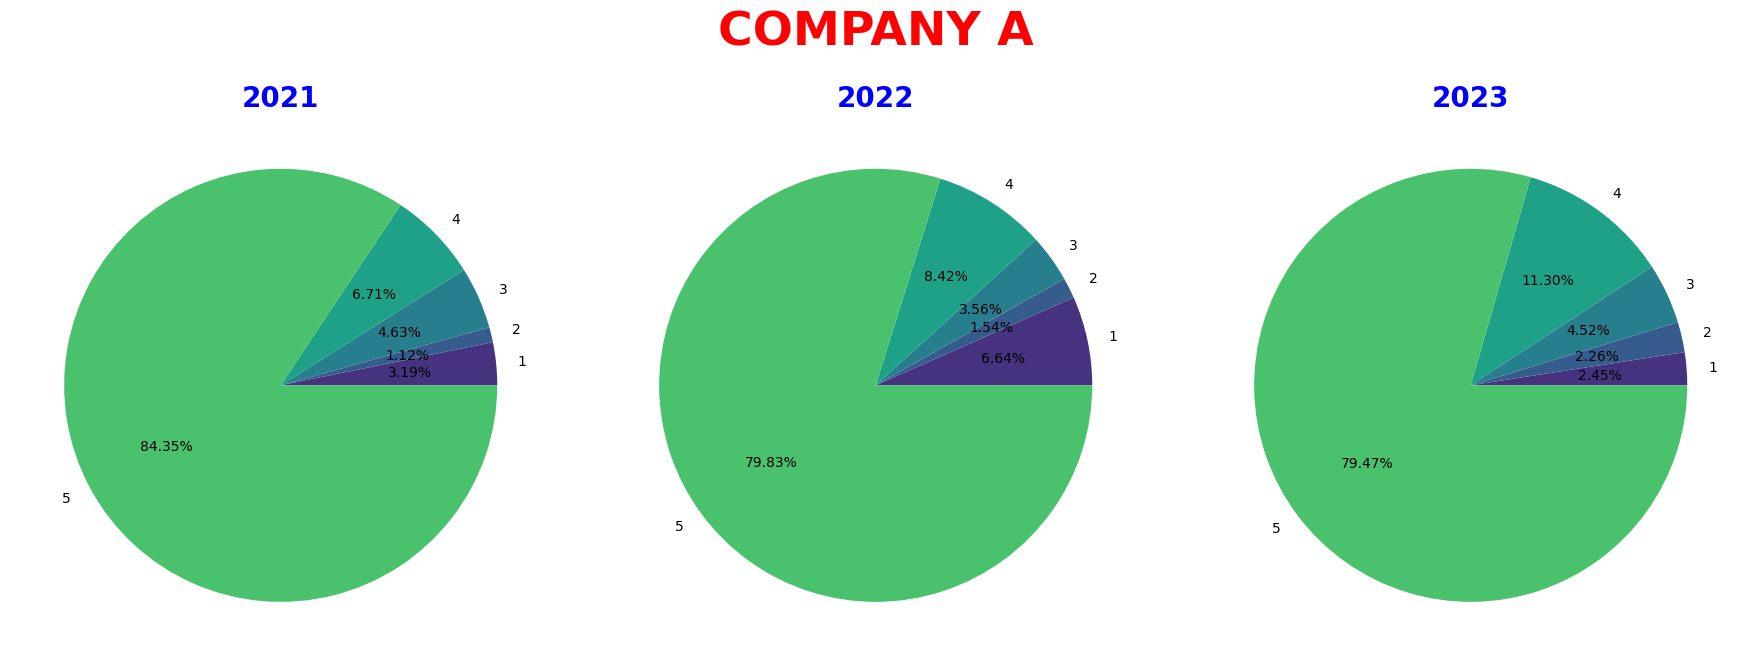

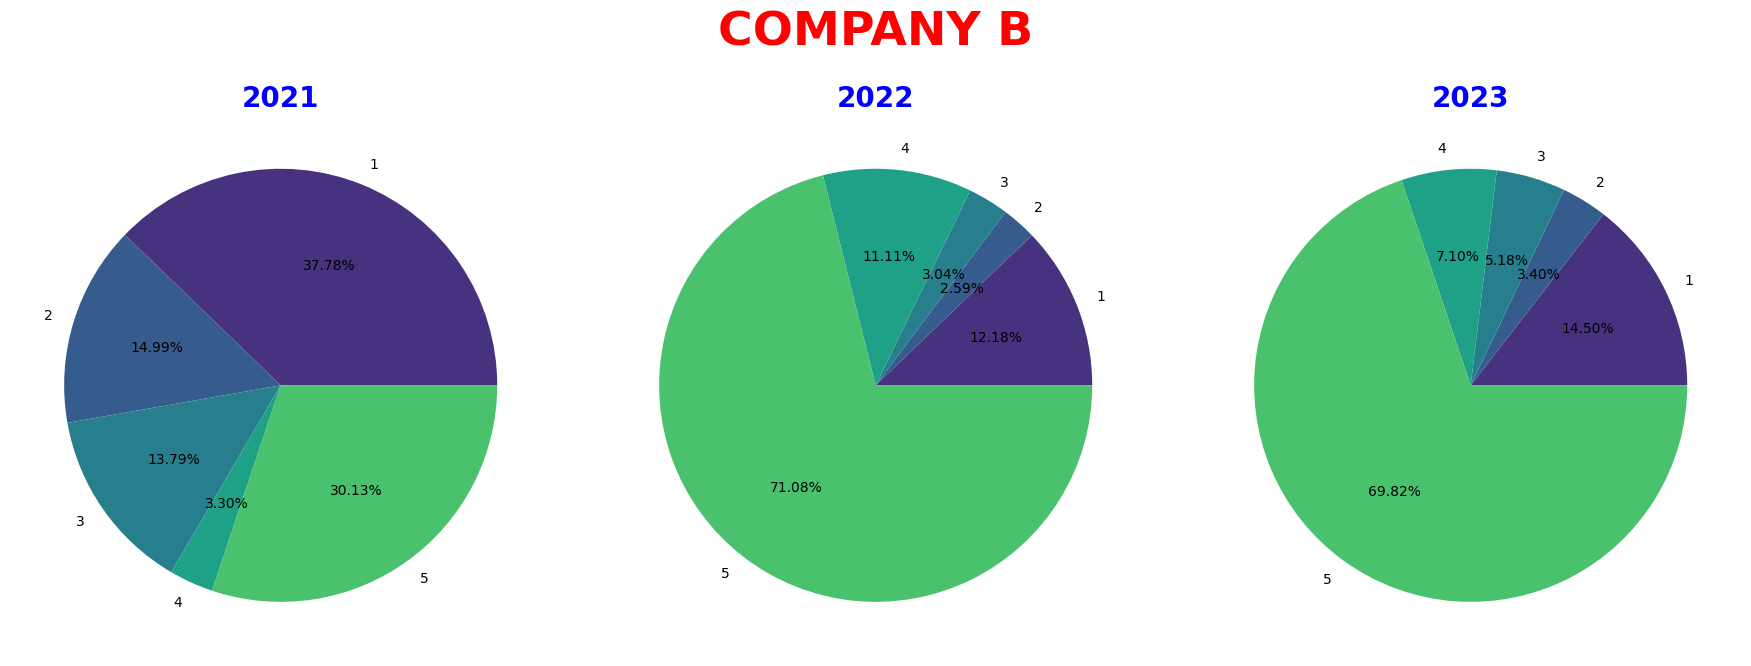

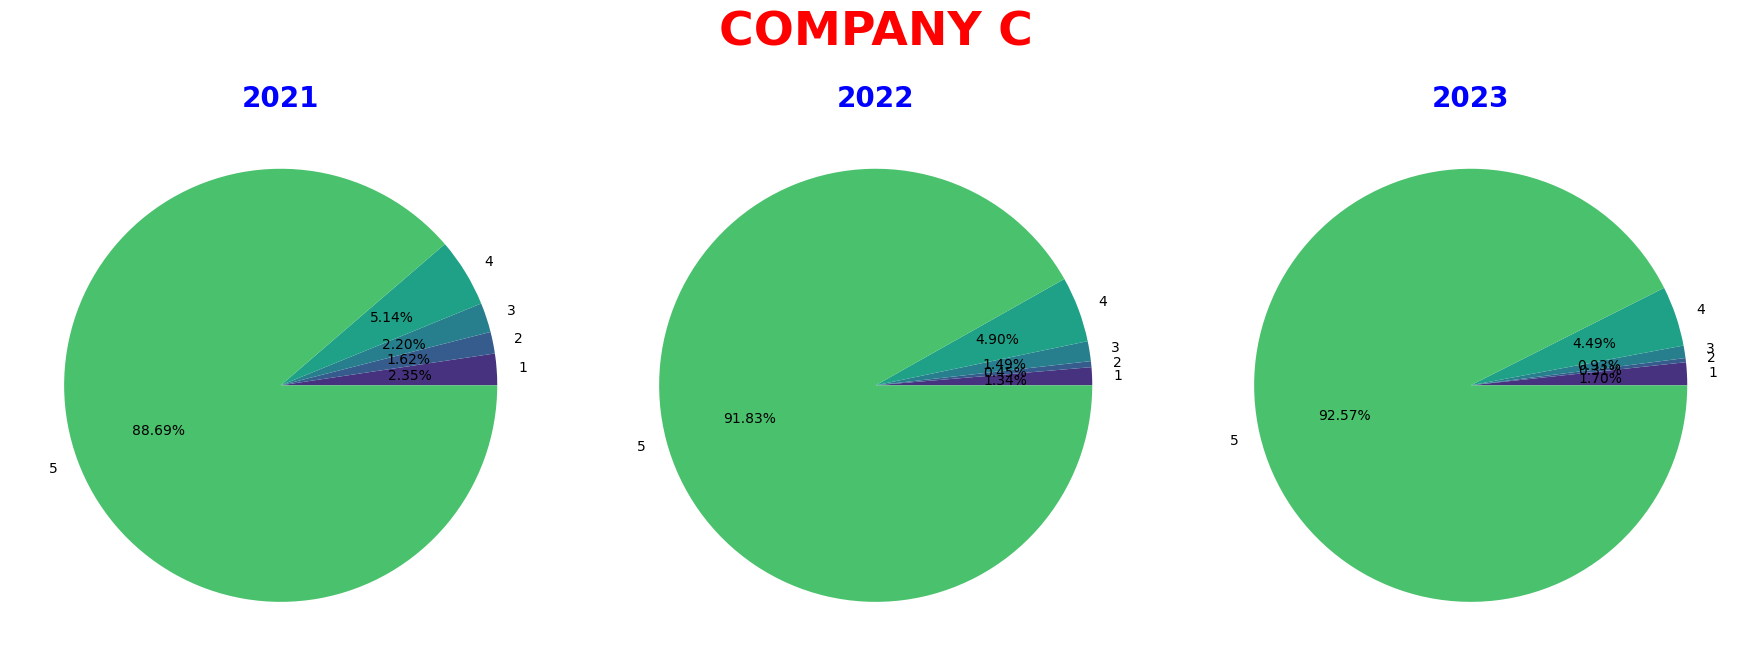

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_company_mean_ratings_pie(company_df, company_name):
    # Define years to plot
    years = [2021, 2022, 2023]

    # General title for the entire subplot
    general_title = f'{company_name}'

    # Plot pie charts for mean ratings for the company for each year
    plt.figure(figsize=(18, 18))

    for i, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the pie chart
        subplot_index = i + 1
        ax = plt.subplot(3, 3, subplot_index)

        # Plot pie chart
        plt.pie(mean_ratings, labels=mean_ratings.index.astype(str), autopct='%1.2f%%', colors=sns.color_palette("viridis"))

        # Add labels and title
        plt.title(f'{year}', fontsize=20, fontweight='bold', color='blue')

        # Add y-labels for the first column
        if subplot_index % 3 == 1:
            plt.ylabel('', fontsize=18, fontweight='bold', color='blue')

    # General title for the entire subplot
    plt.suptitle(general_title, fontsize=34, fontweight='bold', y=1, color='red')

    # Adjust layout with a gap between subplots
    plt.tight_layout(h_pad=2)

    # Show the plot
    plt.show()

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
plot_company_mean_ratings_pie(sampled_df1, 'COMPANY A')
plot_company_mean_ratings_pie(sampled_df2, 'COMPANY B')
plot_company_mean_ratings_pie(sampled_df3, 'COMPANY C')


# Yearly

<ipython-input-145-be08f23e14f8>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


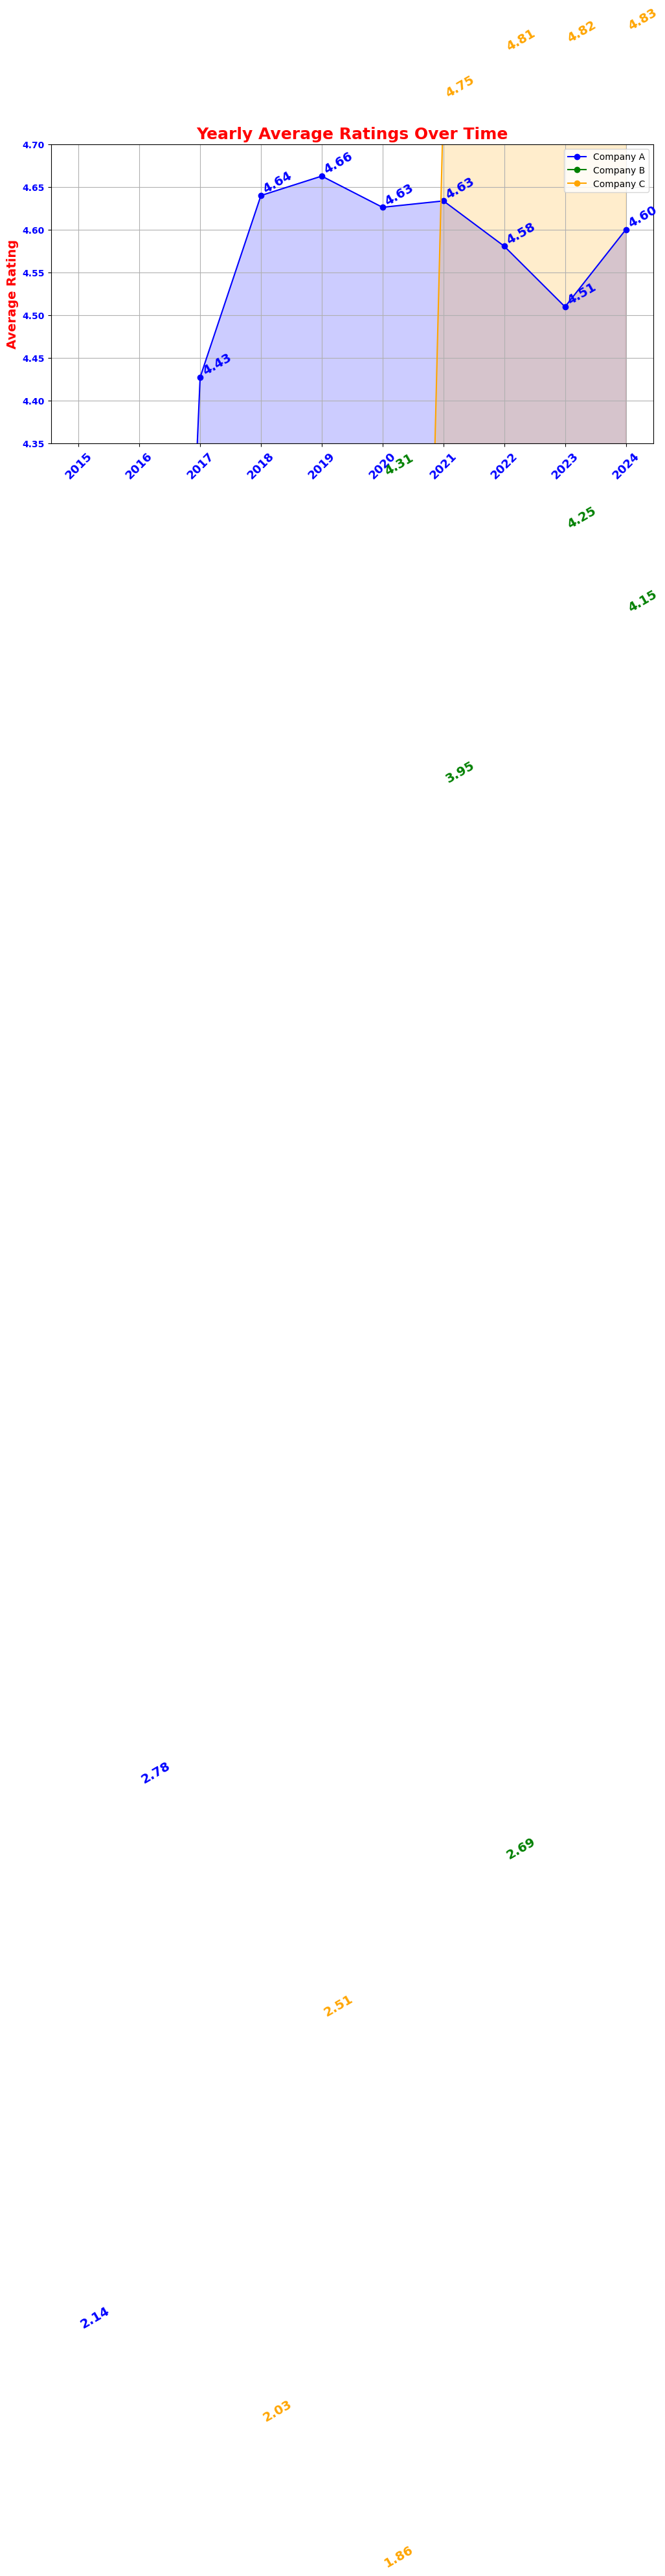

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df1, df2, and df3 are your three DataFrames

# Create a function to plot yearly average ratings
def plot_yearly_ratings(df, color, label):
    yearly_ratings = df.resample('Y', on='Review Date')['Rating'].mean().dropna()

    plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', color=color, label=label)
    plt.fill_between(yearly_ratings.index, yearly_ratings.values, color=color, alpha=0.2)

    for x, y in zip(yearly_ratings.index, yearly_ratings.values):
        plt.text(x, y, f'{y:.2f}', ha='left', va='bottom', fontsize=14, fontweight='bold', color=color, rotation=30)

# Create a time series plot for each DataFrame
plt.figure(figsize=(12, 6))

plot_yearly_ratings(df1, color='blue', label='Company A')
plot_yearly_ratings(df2, color='green', label='Company B')
plot_yearly_ratings(df3, color='orange', label='Company C')

# Set the y-axis range if needed
plt.ylim(4.35, 4.7)

# Add labels and title
plt.title('Yearly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')
plt.xlabel('')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold', color='red')
plt.grid(True)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Make y-axis labels bold
plt.yticks(fontweight='bold', color='blue')
plt.xticks(fontweight='bold', fontsize=13, rotation=45, color='blue')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to DataFrames
yearly_ratings_df1 = df1.resample('Y', on='Review Date')['Rating'].mean().dropna().to_frame().reset_index()
yearly_ratings_df1.columns = ['Year', 'Average Rating']

yearly_ratings_df2 = df2.resample('Y', on='Review Date')['Rating'].mean().dropna().to_frame().reset_index()
yearly_ratings_df2.columns = ['Year', 'Average Rating']

yearly_ratings_df3 = df3.resample('Y', on='Review Date')['Rating'].mean().dropna().to_frame().reset_index()
yearly_ratings_df3.columns = ['Year', 'Average Rating']

# Save the DataFrames to CSV files
yearly_ratings_df1.to_csv('yearly_ratings_company_a.csv', index=False)
yearly_ratings_df2.to_csv('yearly_ratings_company_b.csv', index=False)
yearly_ratings_df3.to_csv('yearly_ratings_company_c.csv', index=False)


# Quarterly

In [ ]:
import matplotlib.pyplot as plt

# Group data by quarter and calculate the mean rating for each quarter
quarterly_mean_rating = df.groupby(df['Review Date'].dt.to_period('Q')).agg({'Rating': 'mean'})

# Create a line plot for quarterly mean rating with enhanced styling
plt.figure(figsize=(12, 6))

# Plot the line
plt.plot(
    quarterly_mean_rating.index.strftime('%b %Y'),
    quarterly_mean_rating['Rating'],
    marker='o',
    color='skyblue',
    linewidth=2,
    markersize=8,
)

# Fill the area below the line with light green color
plt.fill_between(
    quarterly_mean_rating.index.strftime('%b %Y'),
    quarterly_mean_rating['Rating'],
    color='lightgreen',  # Specify the fill color as light green
    alpha=0.3,  # Adjust transparency of the fill
)

# Set the y-axis range to 4 to 5
plt.ylim(4.25, 4.7)

# Add labels and titles
plt.title('Quarterly Mean Rating', fontsize=16, fontweight='bold', color='black')  # Default title color
plt.xlabel('', fontsize=14, fontweight='bold')
plt.ylabel('Mean Rating', fontsize=16, fontweight='bold')

# Rotate x-axis labels for readability (rotate 45 degrees)
plt.xticks(rotation=45, ha="right", fontsize=12)

# Annotate data values on the line plot and draw lines to x-axis
for x, y in zip(quarterly_mean_rating.index.strftime('%b %Y'), quarterly_mean_rating['Rating']):
    plt.annotate(
        f'{y:.2f}',
        (x, y),
        textcoords='offset points',
        xytext=(0, -15),  # Adjust the y-coordinate to move labels to the bottom
        ha='right',  # Rotate 45 degrees
        fontsize=9,
        color='blue',
        fontweight='bold',
        rotation=45,  # Rotate the label
    )
    plt.vlines(x, 3.5, y, colors='gray', linestyles='dotted', lw=1)

# Show the plot
plt.tight_layout()

# Set the title font properties
title = plt.title('Quarterly Mean Rating', fontsize=20, fontweight='bold', color='red')  # Updated title color

# Show the plot
plt.show()


# Monthly

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming you have a DataFrame named df with a 'Review Date' column and a 'Rating' column

# Downsample the data by averaging ratings by month
monthly_ratings = df.resample('M', on='Review Date')['Rating'].mean().dropna()

# Create a time series plot of downsampled ratings
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index, monthly_ratings.values, marker='o', linestyle='-', color='b', label='Average Rating')
plt.fill_between(monthly_ratings.index, monthly_ratings.values, color='lightgreen', alpha=0.3)  # Fill the area under the line with light green

# Add vertical lines between x-axis and points
for date, rating in zip(monthly_ratings.index, monthly_ratings.values):
    plt.vlines(date, 4, rating, color='gray', linestyle='--', linewidth=0.8)

plt.title('Monthly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')  # Updated title color
plt.xlabel('')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold', color='red')
plt.grid(True)

# Set x-axis tick locator and formatter for years only
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')  # Display years as four-digit numbers

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Customize x-axis ticks and labels
plt.xticks(fontsize=12, fontweight='bold', color='red', ha='center', rotation=45)

# Customize y-axis ticks and labels
plt.yticks(fontsize=12, fontweight='bold', color='red')

# Set the y-axis range to 4 to 5
plt.ylim(4, 5)

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to a DataFrame
monthly_ratings_df = monthly_ratings.to_frame().reset_index()
monthly_ratings_df.columns = ['Date', 'Average Rating']

# Save the DataFrame to a CSV file
monthly_ratings_df.to_csv('monthly_ratings.csv', index=False)


## Date-Related Calculations:




### a. Calculate Time Difference:


Calculate the time difference between two date columns. For instance, you can calculate the response time by subtracting the review date from the reply date.

In [ ]:
df['Review Response'] = df['Review Date'] - df['Experience Date']

df['Reply Response'] = df['Reply Date'] - df['Review Date']

In [ ]:
df.head()

### b. Extract Date Components:

Extract specific components from the date, such as year, month, day, or weekday.

In [ ]:
df['Year'] = df['Review Date'].dt.year
df['Month'] = df['Review Date'].dt.month
df['Day'] = df['Review Date'].dt.day
df['Weekday'] = df['Review Date'].dt.day_name()

### Ratings Over Time (Monthly Average)

In [ ]:
# Downsample the data by averaging ratings by month
monthly_ratings = df.resample('M', on='Review Date')['Rating'].mean().dropna()

# Create a time series plot of downsampled ratings
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index, monthly_ratings.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')  # Updated title color
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold')
plt.grid(True)

# Set x-axis tick locator and formatter for years only
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')  # Display years as four-digit numbers

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to a DataFrame
monthly_ratings_df = monthly_ratings.to_frame().reset_index()
monthly_ratings_df.columns = ['Date', 'Average Rating']

# Save the DataFrame to a CSV file
monthly_ratings_df.to_csv('monthly_ratings.csv', index=False)

# Display the DataFrame
print("Downsampled Monthly Ratings as DataFrame:")
print(monthly_ratings_df)


### Visualization for Mean Rating by Year and Month:

a. Calculate summary statistics for different time periods, such as the mean rating for each year or month.

In [ ]:
# Mean rating by year
mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named df with a 'Review Date' column and a 'Rating' column

# Calculate the mean rating by year
mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

# Calculate the mean rating by month
mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

# Create subplots for both graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the mean rating by year
ax1.plot(mean_rating_by_year.index, mean_rating_by_year.values, marker='o', linestyle='-', color='b', linewidth=3)  # Increase linewidth
ax1.fill_between(mean_rating_by_year.index, mean_rating_by_year.values, color='lightblue', alpha=0.3)
ax1.set_title('Mean Rating by Year', fontsize=16, color='red', fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
ax1.grid(True)
ax1.set_ylim(4.4, 4.66)  # Set y-axis limits

# Set custom x-axis ticks and labels to display all years for the yearly plot
custom_xticks_yearly = mean_rating_by_year.index
ax1.set_xticks(custom_xticks_yearly)
ax1.set_xticklabels(custom_xticks_yearly, rotation=45, ha='right', fontsize=10, fontweight='bold', color='red')  # Rotating year labels for better readability

# Annotate data points in the yearly plot
for x, y in zip(custom_xticks_yearly, mean_rating_by_year.values):
    ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=13, fontweight='bold', color='green')  # Adjusted fontsize

# Plot the mean rating by month
ax2.plot(mean_rating_by_month.index, mean_rating_by_month.values, marker='o', linestyle='-', color='g', linewidth=3)  # Increase linewidth
ax2.fill_between(mean_rating_by_month.index, mean_rating_by_month.values, color='lightgreen', alpha=0.3)
ax2.set_title('Mean Rating by Month', fontsize=16, color='red', fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
ax2.grid(True)
ax2.set_ylim(4.56, 4.65)  # Set y-axis limits

# Set custom x-axis ticks and labels to display full month names for the monthly plot
custom_xticks_monthly = list(range(1, 13))  # Months 1 to 12
custom_xtick_labels_monthly = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax2.set_xticks(custom_xticks_monthly)
ax2.set_xticklabels(custom_xtick_labels_monthly, rotation=45, ha='right', fontsize=13, fontweight='bold', color='red')  # Adjusted fontsize

# Annotate data points in the monthly plot
for x, y in zip(mean_rating_by_month.index, mean_rating_by_month.values):
    ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=13, fontweight='bold', color='blue')  # Adjusted fontsize

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


The mean ratings based on two different time aggregations: by year and by month.

Let's discuss and conclude the insights from this data:

**Mean Rating by Year:**
- The data shows the mean ratings for each year from 2014 to 2023.
- In 2014, the mean rating was approximately 4.41, indicating a relatively positive sentiment in customer reviews.
- The mean rating increased in 2015 to approximately 4.54, suggesting an improvement in customer satisfaction.
- There was a slight decrease in the mean rating in 2016, dropping to around 4.42.
- Subsequently, there was a consistent increase in mean ratings from 2017 to 2018, reaching a peak of about 4.66.
- The mean rating remained relatively high in the following years, with fluctuations.
- In 2023, the mean rating reached approximately 4.58.

**Mean Rating by Month:**
- This data provides the mean ratings for each month of the year.
- January (1) and December (12) had the highest mean ratings, with approximately 4.60 and 4.65, respectively. These months might correspond to periods of higher customer satisfaction.
- April (4) and October (10) had slightly lower mean ratings, around 4.58.
- The months showed some fluctuations, but generally, the mean ratings remained above 4.57 throughout the year.

**Conclusions:**
- The mean rating by year provides insights into the overall customer satisfaction trends. While there were some fluctuations, it's evident that ratings improved from 2014 to 2018, remained relatively stable until 2022, and saw a slight increase in 2023.
- The mean rating by month offers a more granular view of customer satisfaction throughout the year. January and December had the highest ratings, possibly due to seasonal factors or holidays.
- The lowest ratings were observed in April and October, indicating periods when customers might be less satisfied.

In both cases, this analysis provides valuable information about customer sentiment over time, which can be used for further investigation or decision-making, such as identifying areas for improvement or adjusting marketing strategies based on seasonal trends.

### Time Series Plot of Ratings Over Time:



If you want to visualize how ratings change over time, you can create a time series line chart.

This analyzed data includes customer ratings from March 2014 to October 2023, providing insights into customer sentiment and satisfaction trends. The objective is to inform data-driven decision-making and enhance our services to meet customer expectations.

**Key Findings**

1. **Consistent Positive Sentiment**: The data reveals a consistent positive sentiment among customers, with average ratings ranging between 4.2 and 4.7. This indicates a high level of overall satisfaction with our services.

2. **Seasonal Variations**: Seasonal variations in ratings are observed, with some months showing higher average ratings and others lower. Identifying the factors contributing to these seasonal fluctuations can help optimize service delivery and resource allocation.

3. **Annual Trends**: Over the years, annual trends are evident, with specific periods exhibiting higher or lower average ratings. Understanding these trends can inform strategic planning and resource allocation.

4. **Data-Driven Decisions**: The dataset provides the opportunity to make data-driven decisions for service enhancement. Analyzing customer feedback and its correlation with ratings can guide improvements in specific areas of service delivery.

5. **Competitive Advantage**: Maintaining consistently high ratings positions Freedom Debt Relief Company as a market leader. Leveraging customer satisfaction can attract new clients and bolster our competitive advantage.

**Recommendations**

- Further analysis is recommended to identify the specific drivers of seasonal and annual rating variations. This analysis should include examining customer feedback for insights.
- Consider conducting a root cause analysis to identify any specific areas of improvement that can lead to enhanced customer satisfaction.

Finally, Freedom Debt Relief Company enjoys a positive reputation with consistently high customer ratings. Leveraging this reputation for continuous improvement is essential for maintaining a competitive advantage. By delving deeper into the drivers of rating variations and aligning service delivery with customer expectations, we can further solidify our position in the market.


In [ ]:
# Calculate the mean rating by year
mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

# Print the results
print("Mean Rating by Year:")
print(mean_rating_by_year)

# Create a plot for the mean rating by year
plt.figure(figsize=(12, 6))
plt.plot(mean_rating_by_year.index, mean_rating_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Mean Rating by Year', fontsize=18, fontweight='bold', color='red')  # Title with 18 pt and bold
plt.xlabel('Year', fontsize=12, fontweight='bold')  # xlabel with 12 pt and bold
plt.ylabel('Mean Rating', fontsize=12, fontweight='bold')  # ylabel with 12 pt and bold
plt.grid(True)

# Set custom x-axis ticks and labels to display all years
custom_xticks_yearly = mean_rating_by_year.index
plt.xticks(custom_xticks_yearly, custom_xticks_yearly, rotation=45)  # Rotating year labels for better readability

# Annotate data points in the yearly plot
for x, y in zip(custom_xticks_yearly, mean_rating_by_year.values):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the mean rating by month
mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

# Print the results
print("Mean Rating by Month:")
print(mean_rating_by_month)

# Set seaborn style for enhanced aesthetics
sns.set(style="whitegrid")

# Create a plot for the mean rating by month with enhanced styling
plt.figure(figsize=(12, 6))
plt.plot(mean_rating_by_month.index, mean_rating_by_month.values, marker='o', linestyle='-', color='g', linewidth=2)

# Title with 18 pt and bold
plt.title('Mean Rating by Month', fontsize=18, fontweight='bold', color='red')

# xlabel with 12 pt and bold
plt.xlabel('Month', fontsize=12, fontweight='bold')

# ylabel with 12 pt and bold
plt.ylabel('Mean Rating', fontsize=12, fontweight='bold')

# Set custom x-axis ticks and labels to display all 12 months
custom_xticks_monthly = list(range(1, 13))  # Months 1 to 12
custom_xtick_labels_monthly = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(custom_xticks_monthly, custom_xtick_labels_monthly)  # Custom month labels

# Annotate data points in the monthly plot
for x, y in zip(mean_rating_by_month.index, mean_rating_by_month.values):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Show the plot
plt.tight_layout()
plt.show()


### Histogram of Ratings:



A histogram will show the distribution of ratings. You can see how many ratings fall into each category

In [ ]:
# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a bar plot of ratings
plt.figure(figsize=(8, 6))
rating_counts = df['Rating'].value_counts().sort_index()
ax = plt.bar(rating_counts.index, rating_counts, color='skyblue', edgecolor='black')

# Set custom bar labels at the center of each bar
for bar in ax:
    bar_x = bar.get_x() + bar.get_width() / 2
    bar_height = bar.get_height()
    plt.text(bar_x, bar_height, str(int(bar_height)), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add title, xlabel, and ylabel with specified font sizes and styles
plt.title('Distribution of Ratings', fontsize=18, fontweight='bold', color='red')
plt.xlabel('Rating', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

# Print information about the distribution of ratings
print("Distribution of Ratings:")
print(rating_counts)


The distribution of ratings, as provided in the histogram results, offers insights into how customers have rated a product or service.

Here is a discussion and conclusion based on the given distribution:

**Distribution of Ratings:**
- The data is divided into five rating categories: 1, 2, 3, 4, and 5.
- Each category represents the number of reviews with that particular rating.
- The highest number of reviews falls into the 5-star category, with a count of 30,639.
- The 4-star rating is the second most common, with 4,758 reviews.
- The 3-star rating has a count of 1,622.
- The 2-star rating is the least common among positive ratings, with only 694 reviews.
- The lowest rating, 1 star, has a count of 1,365.

**Discussion:**
- The data clearly shows that the majority of customers have given positive ratings, with 5-star and 4-star ratings being the most prevalent. This indicates that a substantial portion of customers are satisfied with the product or service, as these ratings are above the median score (3).
- The distribution is right-skewed, meaning there are far more positive reviews than negative ones. This skew suggests that the product or service generally meets customer expectations or even exceeds them.
- The relatively low counts in the 1-star and 2-star categories suggest that only a minority of customers expressed strong dissatisfaction.
- The 3-star category, while not as common as 4-star and 5-star ratings, still has a notable number of reviews, indicating a moderate level of satisfaction.

**Conclusion:**
The distribution of ratings reflects a generally positive sentiment among customers who have left reviews. The bulk of reviews fall into the higher rating categories, suggesting that the product or service is well-received. However, the existence of lower ratings (1 to 3 stars) indicates that there is room for improvement or that a subset of customers had less positive experiences.

To draw more specific conclusions or make further decisions based on this data, it may be helpful to conduct sentiment analysis on the reviews themselves or to analyze other factors, such as the time of the reviews or the topics mentioned in the reviews. This additional context can provide a deeper understanding of customer feedback.

### TEXT PREPROCESSING

#### Concatenate Review Title and Review Text Columns

In [ ]:
columns_to_concat = ['Review Title', 'Review Text']

# Concatenate the selected columns into a new column 'Concatenated_Text'
df['Concatenated_Text'] = df[columns_to_concat].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

#### Text Preprocessing

Before performing NLP tasks, it's important to preprocess the text data, which typically involves removing stopwords, punctuation, and converting text to lowercase.

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text and store them separately
        emojis = [c for c in text if c in emoji.UNICODE_EMOJI]

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Combine words and emojis back into a preprocessed text
        preprocessed_text = ' '.join(words) + ' '.join(emojis)
        return preprocessed_text
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text
        text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FC00-\U0001FCFF\U0001FD00-\U0001FDFF\U0001FE00-\U0001FEFF\U0001FF00-\U0001FFFF]+', '', text)

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        return ' '.join(words)
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
df['Cleaned_Concatenated_Text'] = df['Concatenated_Text'].apply(preprocess_text)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Assuming df is your DataFrame
df.to_csv('Freedom_Debt_Relief2.csv', index=False)